# Ejercicio 7 - guía 4

Nambe Mills es una fábrica de vajillas. En https://github.com/franciscokordon/estainferencia/blob/main/data/nambeware.csv figuran, entre otros datos, el diámetro y el precio de la vajilla producida durante un período de tiempo fijo.

## a)
Graficar el precio 𝑦 vs el diámetro 𝑥. Justificar por qué un MLG de Gamma es una opción
razonable.

### Desarrollo

Primero cargo los datos:

In [1]:
import pandas as pd
import os

ruta_datos_nambe = os.path.join('..', '..','datos', 'raw' ,'nambeware.csv')

df_nambe = pd.read_csv(ruta_datos_nambe, index_col=0)

df_nambe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 58
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Type    59 non-null     object 
 1   Diam    59 non-null     float64
 2   Time    59 non-null     float64
 3   Price   59 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.3+ KB


Analizo como se distribuyen las variables que se verán implicadas en la estimación:

Text(0.5, 0, 'Precio de la vajilla')

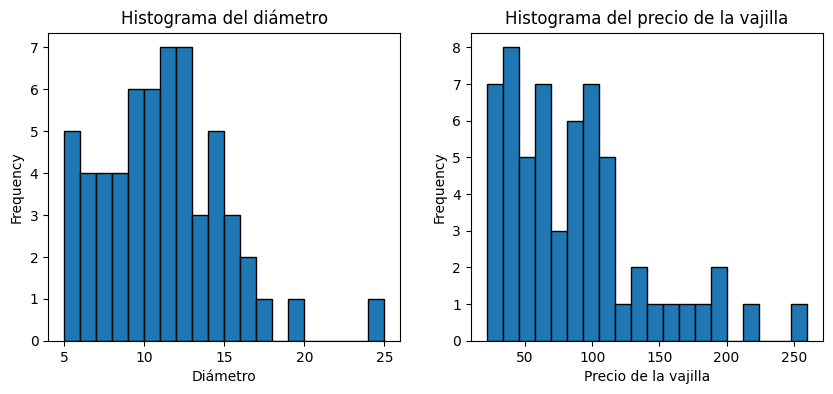

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# en el primer eje hago un histograma de la variable "Diam"
df_nambe['Diam'].plot.hist(ax=ax[0], bins=20, edgecolor='black')
ax[0].set_title('Histograma del diámetro')
ax[0].set_xlabel('Diámetro')

# en el segundo eje hago un histograma de la variable "Price"
df_nambe['Price'].plot.hist(ax=ax[1], bins=20, edgecolor='black')
ax[1].set_title('Histograma del precio de la vajilla')
ax[1].set_xlabel('Precio de la vajilla')

Y ahora hago el gráfico del diámetro vs el precio de la vajilla:

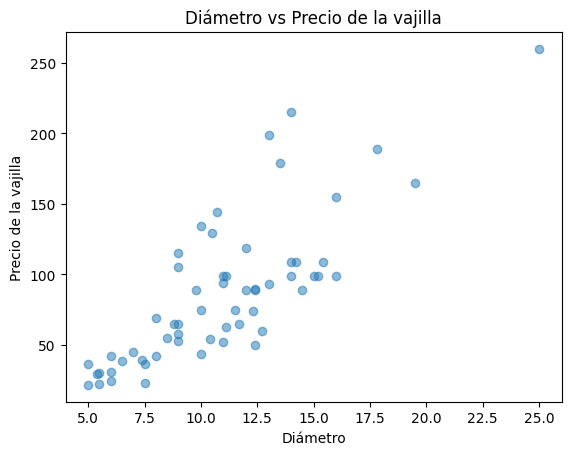

In [3]:
plt.scatter(df_nambe['Diam'], df_nambe['Price'], alpha=0.5)
plt.xlabel('Diámetro')
plt.ylabel('Precio de la vajilla')
plt.title('Diámetro vs Precio de la vajilla')
plt.show()

Es posible observar a partir del gráfico y los histogramas que hay un valor atípico entre nuestros datos, lo cúal podría perjudicar a nuestras estimaciones, dicho valor está para valores del diámetro mayores a 20. Por lo tanto para evitar problemas procedo a eliminarlo:

In [4]:
df_nambe = df_nambe[df_nambe['Diam'] < 20]

Resultando ahora en el mismo gráfico pero sin dicho dato atípico:

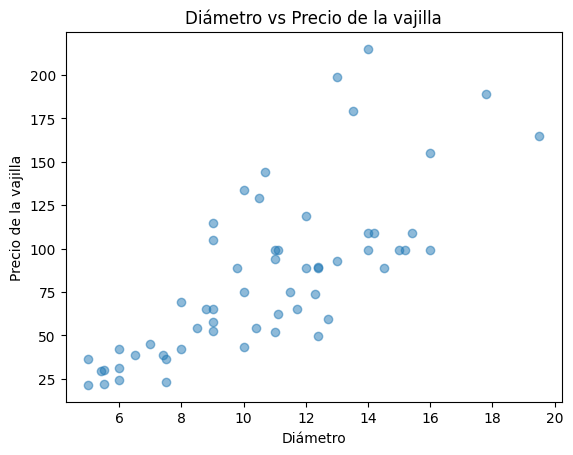

In [5]:
plt.scatter(df_nambe['Diam'], df_nambe['Price'], alpha=0.5)
plt.xlabel('Diámetro')
plt.ylabel('Precio de la vajilla')
plt.title('Diámetro vs Precio de la vajilla')
plt.show()

Una forma de justificar que la distribución Gamma puede ser razonable para modelar estos datos puede ser analizando la relación media-varianza de los datos observados. Por lo tanto procedo a hacer dicho análisis

In [6]:
# Separo el df en 3 grupos de acuerdo al diametro
df_nambe['diam_cut'] = pd.cut(df_nambe['Diam'], bins=4)

# Calculo la media y varianza de cada grupo
df_agrupado = df_nambe.groupby('diam_cut')['Price']
medias = df_agrupado.mean()
varianzas = df_agrupado.var()
longitudes = df_agrupado.size()

# Muestro el resultado en formato de tabla
df_resultado = pd.DataFrame({'Media': medias, 'Varianza': varianzas, 'Longitud': longitudes})
df_resultado

C:\Users\gerar\AppData\Local\Temp\ipykernel_8912\2178772946.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agrupado = df_nambe.groupby('diam_cut')['Price']


,Media,Varianza,Longitud
diam_cut,,,
"(4.986, 8.625]",36.531250,160.415625,16
"(8.625, 12.25]",85.613636,868.307900,22
"(12.25, 15.875]",110.031250,2211.382292,16
"(15.875, 19.5]",152.000000,1452.000000,4


Aquí obtuve la media, varianza y longitud para cada grupo que armé en función del diámetro de las vajillas, pero algo más interesante sería analizar
la relación log(media) - log(varianza), para así tener una ídea del grado de la relación. Paso a hacer dicho análisis:

Intercepto: -1.1107105370256463, Pendiente: 1.7594007407415373


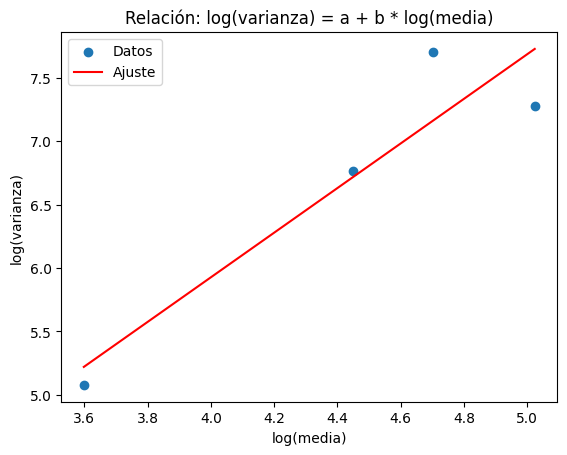

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from utils.regresiones import estimar_bethas

# Tomo log de la media y varianza
x, y = np.log(medias), np.log(varianzas)

# Ahora tengo una relación de la forma log(varianza) = a + b * log(media), estimo a y b para conocer el grado de la relación
x_intercepto = np.column_stack((np.ones_like(x), x))
b0, b1 = estimar_bethas(x_intercepto, y)
print(f'Intercepto: {b0}, Pendiente: {b1}')

# Ahora hago un gráfico que muestre la recta ajustada y los puntos
plt.scatter(x, y, label='Datos')
plt.plot(x, b0 + b1 * x, color='red', label='Ajuste')
plt.title('Relación: log(varianza) = a + b * log(media)')
plt.xlabel('log(media)')
plt.ylabel('log(varianza)')
plt.legend()
plt.show()

Ahora tenemos que, el valor de b estimado para la relación media-varianza es apróximadamente 1.75, lo cual está más cerca de 2, por lo tanto se puede considerar que la relación es de **grado 2**.

Y como nuestro objetivo era justificar el uso de una distribución Gamma para ajustar estos datos, podemos decir que lo logramos ya que es la única distribución cuyo grado de relación media-varianza es 2. Además que nuestra variable objetivo "Price", justamente es un precio, lo cual implica que toma valores continuos.  

## b)
Ajustar este MLG, es decir, encontrar estimaciones puntuales para los parámetros de regresión 𝛽.

### Desarrollo

In [10]:
import statsmodels.api as sm

# Armo la matriz de diseño 
X = df_nambe['Diam']
interceptos = np.ones(X.shape)
X_intercepto = np.column_stack((interceptos, X))

# Armo la variable objetivo
Y = df_nambe['Price']

# Definir la familia de distribución como Gamma
gamma_family = sm.families.Gamma()

# Crear el modelo GLM
model = sm.GLM(Y, X, family=gamma_family)

# Ajustar el modelo
result = model.fit()

# Ver los resultados del ajuste
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Price   No. Observations:                   58
Model:                            GLM   Df Residuals:                       57
Model Family:                   Gamma   Df Model:                            0
Link Function:           InversePower   Scale:                         0.61490
Method:                          IRLS   Log-Likelihood:                -320.97
Date:                Wed, 18 Sep 2024   Deviance:                       38.696
Time:                        21:27:43   Pearson chi2:                     35.0
No. Iterations:                     7   Pseudo R-squ. (CS):            -0.7676
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Diam           0.0010      0.000      9.712      0.0

c:\Users\gerar\OneDrive\Documentos\Mis Archivos\Estadistica e Inferencia\estat_inferencia\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
